## K-Means Clustering Algorithm

This project implements and compares custom K-Means clustering with scikit-learn's implementation across three datasets: Iris, AI Global Index, and Global Earthquake data. Below is the enhanced code with detailed comments and markdown explanations.

# Table of Contents

1. Dataset Preparation
2. Custom K-Means Implementation
3. Evaluation Metrics
4. Mixed Data Dissimilarity Handling
5. Experiments and Results
6. Iris Dataset Analysis
7. Weighted Feature K-Means


## Dataset Preparation

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score, adjusted_mutual_info_score, mutual_info_score
from collections import deque
import importlib

# Load datasets
dataset_path = "./../datasets"

iris_dataset_path = dataset_path + "/iris.csv"                                         
ai_global_index_path = dataset_path + "/AI_index_db.csv"
global_earthquake_data_path = dataset_path + "/earthquakes.csv"

# Read datasets into DataFrames
iris_df = pd.read_csv(iris_dataset_path)
print(iris_df.head())
ai_global_index_df = pd.read_csv(ai_global_index_path)
global_earthquake_data_df = pd.read_csv(global_earthquake_data_path)

# Store true labels and remove them from features
true_labels_iris = iris_df['species']
iris_df = iris_df.drop(columns=['species'])

true_labels_ai_global_index = ai_global_index_df['Cluster']
ai_global_index_df = ai_global_index_df.drop(columns=['Country', 'Cluster'])

# Define categorical and numerical columns for AI Global Index dataset
ai_global_index_categorical_cols = ['Income group', 'Political regime', 'Region']
ai_global_index_numerical_cols = [
    "Talent", "Infrastructure", "Operating Environment", 
    "Research", "Development", "Government Strategy", 
    "Commercial", "Total score"
]

# Map categorical values to numerical for AI Global Index
income_order = {'Lower middle': 0, 'Upper middle': 1, 'High': 2}
ai_global_index_df['Income group'] = ai_global_index_df['Income group'].map(income_order)

# Prepare earthquake data
true_labels_global_earthquake_data = global_earthquake_data_df['status']
print(true_labels_global_earthquake_data)

# Drop irrelevant columns from earthquake data
earthquake_drop_cols = [
    'id', 'title', 'date', 'time', 'updated', 'url', 'detailUrl', 
    'ids', 'sources', 'types', 'place', 'placeOnly', 'location', 
    'what3words', 'locationDetails'
]
global_earthquake_data_df = global_earthquake_data_df.drop(columns=earthquake_drop_cols)
print(global_earthquake_data_df.describe())

# Define categorical and numerical columns for earthquake data
earthquake_categorical_cols = [
    'type', 'alert', 'status', 'net', 'magType', 'geometryType',
    'continent', 'country', 'subnational', 'city', 'locality', 'postcode', 'timezone'
]
earthquake_numerical_cols = [
    "magnitude", "felt", "cdi", "mmi", "tsunami", "sig",
    "nst", "dmin", "rms", "gap", "depth", "latitude",
    "longitude", "distanceKM"
]

# Package datasets for easy access
datasets = {
    "iris": (iris_df, true_labels_iris),
    "ai_global_index": (ai_global_index_df, true_labels_ai_global_index),
    "global_earthquake": (global_earthquake_data_df, None)
}

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
0       reviewed
1       reviewed
2       reviewed
3       reviewed
4       reviewed
          ...   
1132    reviewed
1133    reviewed
1134    reviewed
1135    reviewed
1136    reviewed
Name: status, Length: 1137, dtype: object
         magnitude           felt          cdi          mmi      tsunami  \
count  1137.000000    1137.000000  1137.000000  1137.000000  1137.000000   
mean      4.856675     414.408091     2.925242     4.320141     0.059807   
std       1.047840    5746.971362     2.562707     1.453949     0.237232   
min       3.000000       0.000000     0.000000     1.000000     0.000000   
25%    

## Custom K-Means Implementation

In [2]:
class CustomKMeans:
    """Custom implementation of the K-Means clustering algorithm."""
    
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-6, random_state=None):
        """
        Initialize K-Means parameters.
        
        Parameters:
        - n_clusters: Number of clusters (k)
        - max_iter: Maximum number of iterations
        - tol: Tolerance for centroid convergence
        - random_state: Seed for random initialization
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.labels_ = None
        self.random_state = random_state

    def fit(self, X):
        """Fit the model to the data X."""
        np.random.seed(self.random_state)  
        n_samples, n_features = X.shape
        
        # Initialize centroids randomly
        self.centroids = X[np.random.choice(n_samples, self.n_clusters, replace=False)]

        for iteration in range(self.max_iter):
            # Assign clusters by finding nearest centroid for each point
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            self.labels_ = np.argmin(distances, axis=1)

            # Update centroids
            new_centroids = np.zeros_like(self.centroids)
            for i in range(self.n_clusters):
                cluster_points = X[self.labels_ == i]
                if len(cluster_points) == 0:
                    new_centroids[i] = X[np.random.choice(n_samples)]  # reinit empty centroid
                else:
                    new_centroids[i] = cluster_points.mean(axis=0)
                    
            # Check for convergence
            if np.allclose(self.centroids, new_centroids, atol=self.tol):
                break

            self.centroids = new_centroids

    def predict(self, X):
        """Predict cluster labels for new data X."""
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

## Evaluation Metrics

In [3]:
def evaluate_clustering(X, predicted_labels, true_labels=None):
    """
    Evaluate clustering performance using multiple metrics.
    
    Parameters:
    - X: Input data
    - predicted_labels: Cluster labels from the algorithm
    - true_labels: Ground truth labels (optional)
    
    Returns:
    Dictionary of evaluation metrics
    """
    unique_labels = np.unique(predicted_labels)
    
    # Handle invalid clustering results
    if len(unique_labels) < 2:
        return {
            "silhouette_score": -1,
            "davies_bouldin_score": float("inf"),
            "calinski_harabasz_score": -1,
            "adjusted_rand_score": -1,
            "adjusted_mutual_info_score": -1,
            "mutual_info_score": -1
        }

    # Compute clustering metrics
    scores = {
        "silhouette_score": silhouette_score(X, predicted_labels),
        "davies_bouldin_score": davies_bouldin_score(X, predicted_labels),
        "calinski_harabasz_score": calinski_harabasz_score(X, predicted_labels),
    }

    # Compute external validation metrics if true labels are available
    if true_labels is not None:
        scores["adjusted_rand_score"] = adjusted_rand_score(true_labels, predicted_labels)
        scores["adjusted_mutual_info_score"] = adjusted_mutual_info_score(true_labels, predicted_labels)
        scores["mutual_info_score"] = mutual_info_score(true_labels, predicted_labels)
    else:
        scores["adjusted_rand_score"] = -1
        scores["adjusted_mutual_info_score"] = -1
        scores["mutual_info_score"] = -1

    return scores

## Mixed Data Dissimilarity Handling

In [4]:
class MixedDataDissimilarity:
    """Handles dissimilarity computation for datasets with mixed numerical and categorical features."""
    
    def __init__(self, numeric_cols, categorical_cols):
        """
        Initialize with column names for numerical and categorical features.
        
        Parameters:
        - numeric_cols: List of numerical column names
        - categorical_cols: List of categorical column names
        """
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols
        self.min_vals = {}
        self.max_vals = {}

    def fit(self, df):
        """Compute and store min-max values for numeric columns normalization."""
        for col in self.numeric_cols:
            self.min_vals[col] = df[col].min()
            self.max_vals[col] = df[col].max()
            if self.max_vals[col] == self.min_vals[col]:  # Avoid division by zero
                self.max_vals[col] += 1e-9

    def _compute_dissimilarity(self, row1, row2):
        """Compute dissimilarity between two rows."""
        # Compute normalized numerical difference
        num_diff = 0.0
        for col in self.numeric_cols:
            norm_i = (row1[col] - self.min_vals[col]) / (self.max_vals[col] - self.min_vals[col])
            norm_j = (row2[col] - self.min_vals[col]) / (self.max_vals[col] - self.min_vals[col])
            num_diff += abs(norm_i - norm_j)

        # Compute categorical difference (simple matching)
        cat_diff = 0.0
        for col in self.categorical_cols:
            cat_diff += 0 if row1[col] == row2[col] else 1

        # Combine with equal weight
        total_attrs = len(self.numeric_cols) + len(self.categorical_cols)
        return (num_diff + cat_diff) / total_attrs

    def transform(self, df):
        """Compute the full pairwise dissimilarity matrix."""
        n = len(df)
        dist_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                diff = self._compute_dissimilarity(df.iloc[i], df.iloc[j])
                dist_matrix[i, j] = diff
                dist_matrix[j, i] = diff  # symmetric
        return dist_matrix

    def fit_transform(self, df):
        """Fit and compute the dissimilarity matrix in one step."""
        self.fit(df)
        return self.transform(df)

## Experiments and Results


Processing iris dataset

Best K for iris: 3
Custom K-Means Metrics:
Silhouette Score: 0.5526, Davies-Bouldin Index: 0.6623, Calinski-Harabasz Index: 560.3999, adjusted_rand_score: 0.7302, adjusted_mutual_info_score: 0.7551, mutual_info_score: 0.8256 
Sklearn K-Means Metrics:
Silhouette Score: 0.5510, Davies-Bouldin Index: 0.6664, Calinski-Harabasz Index: 560.3660, adjusted_rand_score: 0.7163, adjusted_mutual_info_score: 0.7387, mutual_info_score: 0.8090 


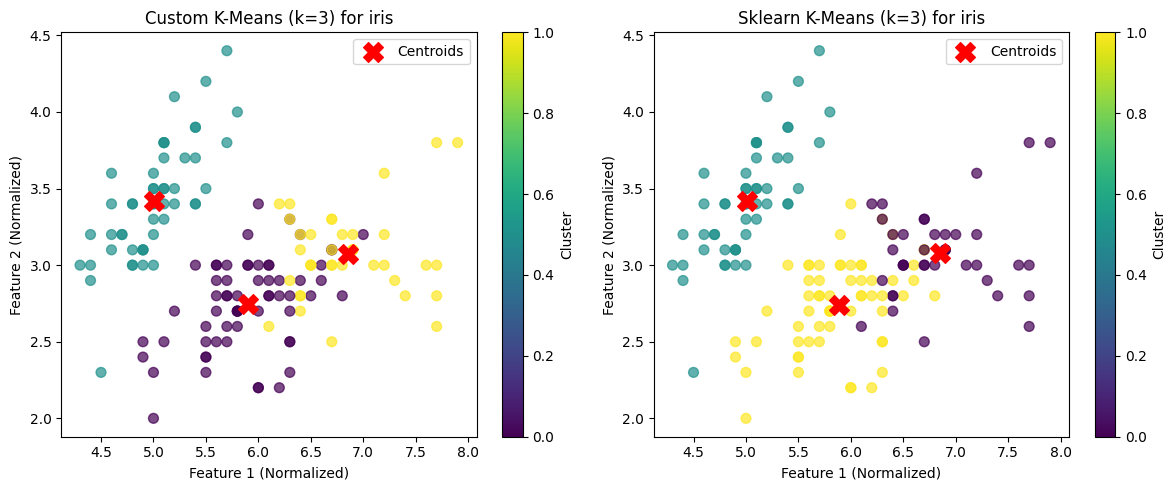


Processing ai_global_index dataset

Best K for ai_global_index: 3
Custom K-Means Metrics:
Silhouette Score: 0.4267, Davies-Bouldin Index: 0.8834, Calinski-Harabasz Index: 51.4940, adjusted_rand_score: 0.1167, adjusted_mutual_info_score: 0.1986, mutual_info_score: 0.2702 
Sklearn K-Means Metrics:
Silhouette Score: 0.4838, Davies-Bouldin Index: 0.8009, Calinski-Harabasz Index: 42.7065, adjusted_rand_score: 0.0864, adjusted_mutual_info_score: 0.3131, mutual_info_score: 0.3290 


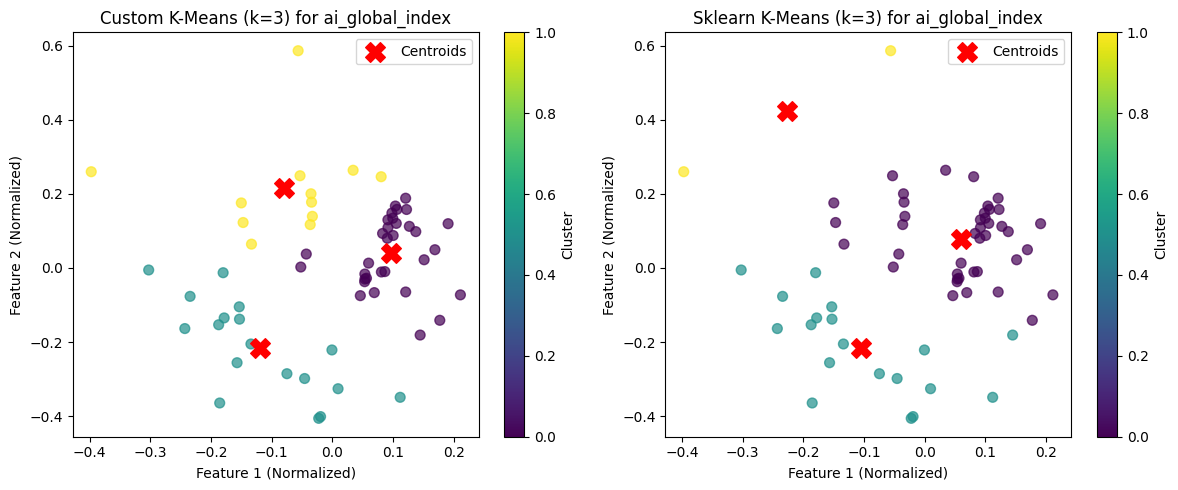


Processing global_earthquake dataset

Best K for global_earthquake: 5
Custom K-Means Metrics:
Silhouette Score: 0.7179, Davies-Bouldin Index: 0.4008, Calinski-Harabasz Index: 428.7644, adjusted_rand_score: -1.0000, adjusted_mutual_info_score: -1.0000, mutual_info_score: -1.0000 
Sklearn K-Means Metrics:
Silhouette Score: 0.6231, Davies-Bouldin Index: 0.3935, Calinski-Harabasz Index: 230.0016, adjusted_rand_score: -1.0000, adjusted_mutual_info_score: -1.0000, mutual_info_score: -1.0000 


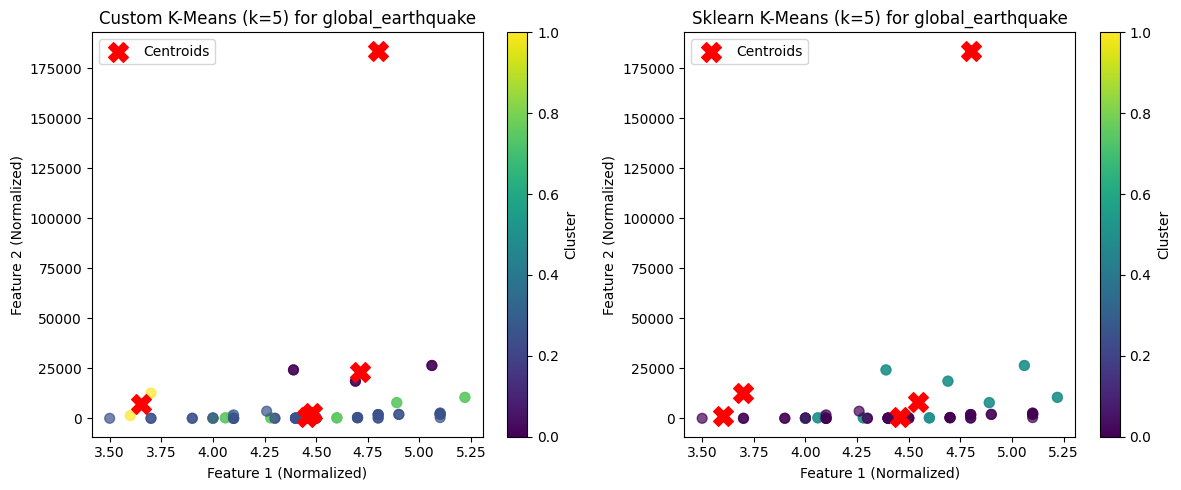

In [5]:
# Initialize results storage
results = {}
k_range = range(3, 6)  # Try different values of k from 3 to 5

for name, (original_df, true_labels) in datasets.items():
    print(f"\nProcessing {name} dataset")
    df = original_df.dropna()
    
    # Preprocess data based on dataset type
    if name == "ai_global_index":
        # Special handling for mixed data types
        numeric_cols = [
            "Talent", "Infrastructure", "Operating Environment", 
            "Research", "Development", "Government Strategy", 
            "Commercial", "Total score"
        ]
        categorical_cols = ["Income group", "Political regime", "Region"]

        # Compute dissimilarity matrix
        dissim = MixedDataDissimilarity(numeric_cols, categorical_cols)
        dist_matrix = dissim.fit_transform(df)

        # Convert dissimilarity matrix to 2D embedding for visualization
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        X = mds.fit_transform(dist_matrix)
    else:
        # For purely numerical datasets
        X = df.select_dtypes(include=[np.number]).values
        
    # Evaluate for different k values
    best_k = None
    best_silhouette = -1  # Start with the worst possible silhouette
    k_results = {}

    for k in k_range:
        # Custom KMeans
        custom_kmeans = CustomKMeans(n_clusters=k, max_iter=100, tol=1e-4, random_state=42)
        custom_kmeans.fit(X)
        custom_labels = custom_kmeans.labels_

        # Sklearn KMeans
        sklearn_kmeans = SklearnKMeans(n_clusters=k, max_iter=100, tol=1e-4, random_state=42)
        sklearn_kmeans.fit(X)
        sklearn_labels = sklearn_kmeans.labels_
        
        # Evaluate both implementations
        custom_metrics = evaluate_clustering(X, custom_labels, true_labels=true_labels)
        sklearn_metrics = evaluate_clustering(X, sklearn_labels, true_labels=true_labels)

        # Store results
        k_results[k] = {
            "custom": {
                "silhouette": custom_metrics['silhouette_score'],
                "davies_bouldin": custom_metrics['davies_bouldin_score'],
                "calinski_harabasz": custom_metrics['calinski_harabasz_score'],
                "adjusted_rand_score": custom_metrics['adjusted_rand_score'],
                "adjusted_mutual_info_score": custom_metrics['adjusted_mutual_info_score'],
                "mutual_info_score": custom_metrics['mutual_info_score'],
                "labels": custom_labels,
                "centroids": custom_kmeans.centroids
            },
            "sklearn": {
                "silhouette": sklearn_metrics['silhouette_score'],
                "davies_bouldin": sklearn_metrics['davies_bouldin_score'],
                "calinski_harabasz": sklearn_metrics['calinski_harabasz_score'],
                "adjusted_rand_score": sklearn_metrics['adjusted_rand_score'],
                "adjusted_mutual_info_score": sklearn_metrics['adjusted_mutual_info_score'],
                "mutual_info_score": sklearn_metrics['mutual_info_score'],
                "labels": sklearn_labels,
                "centroids": sklearn_kmeans.cluster_centers_
            }
        }

        # Track best silhouette score
        if custom_metrics['silhouette_score'] > best_silhouette:
            best_silhouette = custom_metrics['silhouette_score']
            best_k = k

    # Store final result for the dataset
    results[name] = {
        "best_k": best_k,
        "best_metrics": k_results[best_k]
    }

    # Print best result
    print(f"\nBest K for {name}: {best_k}")
    print("Custom K-Means Metrics:")
    print(f"Silhouette Score: {k_results[best_k]['custom']['silhouette']:.4f}, "
          f"Davies-Bouldin Index: {k_results[best_k]['custom']['davies_bouldin']:.4f}, "
          f"Calinski-Harabasz Index: {k_results[best_k]['custom']['calinski_harabasz']:.4f}, "
          f"adjusted_rand_score: {k_results[best_k]['custom']['adjusted_rand_score']:.4f}, "
          f"adjusted_mutual_info_score: {k_results[best_k]['custom']['adjusted_mutual_info_score']:.4f}, "
          f"mutual_info_score: {k_results[best_k]['custom']['mutual_info_score']:.4f} ")

    print("Sklearn K-Means Metrics:")
    print(f"Silhouette Score: {k_results[best_k]['sklearn']['silhouette']:.4f}, "
          f"Davies-Bouldin Index: {k_results[best_k]['sklearn']['davies_bouldin']:.4f}, "
          f"Calinski-Harabasz Index: {k_results[best_k]['sklearn']['calinski_harabasz']:.4f}, "
          f"adjusted_rand_score: {k_results[best_k]['sklearn']['adjusted_rand_score']:.4f}, "
          f"adjusted_mutual_info_score: {k_results[best_k]['sklearn']['adjusted_mutual_info_score']:.4f}, "
          f"mutual_info_score: {k_results[best_k]['sklearn']['mutual_info_score']:.4f} ")

    # Visualization
    plt.figure(figsize=(12, 5))

    # Custom KMeans plot
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=k_results[best_k]['custom']['labels'], cmap="viridis", s=50, alpha=0.7)
    plt.scatter(k_results[best_k]['custom']['centroids'][:, 0], k_results[best_k]['custom']['centroids'][:, 1],
                c="red", marker="X", s=200, label="Centroids")
    plt.title(f"Custom K-Means (k={best_k}) for {name}")
    plt.xlabel("Feature 1 (Normalized)")
    plt.ylabel("Feature 2 (Normalized)")
    plt.legend()
    plt.colorbar(label="Cluster")

    # Sklearn KMeans plot
    plt.subplot(1, 2, 2)
    plt.scatter(X[:, 0], X[:, 1], c=k_results[best_k]['sklearn']['labels'], cmap="viridis", s=50, alpha=0.7)
    plt.scatter(k_results[best_k]['sklearn']['centroids'][:, 0], k_results[best_k]['sklearn']['centroids'][:, 1],
                c="red", marker="X", s=200, label="Centroids")
    plt.title(f"Sklearn K-Means (k={best_k}) for {name}")
    plt.xlabel("Feature 1 (Normalized)")
    plt.ylabel("Feature 2 (Normalized)")
    plt.legend()
    plt.colorbar(label="Cluster")

    plt.tight_layout()
    plt.show()

In [6]:
results_df = pd.DataFrame(results)
results_df.to_csv("./../results/kmeans_result.csv")

## Iris Dataset Analysis

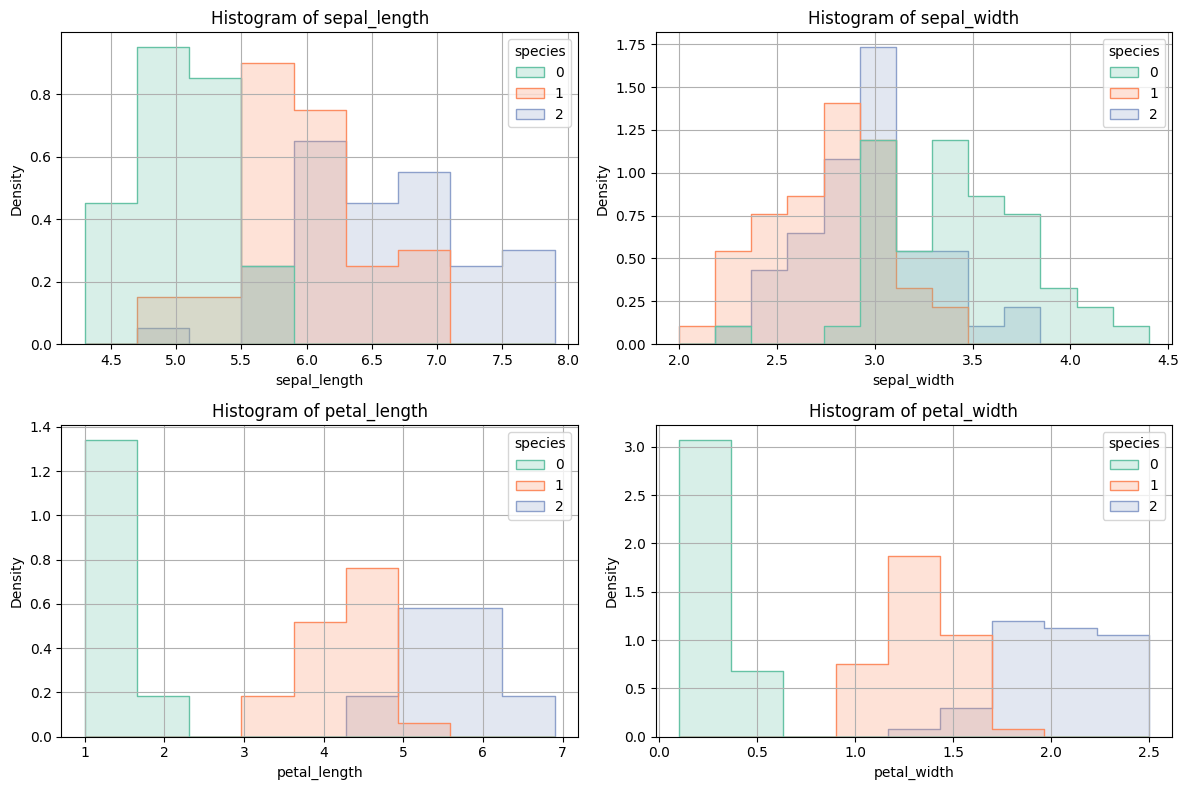

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# Reload iris data with labels for analysis
iris_df = pd.read_csv(iris_dataset_path)

# Map species to numerical labels
label_map = {'setosa':0, 'versicolor':1, 'virginica':2}
iris_df['species'] = iris_df['species'].map(label_map)

# Plot histograms of all features by species
plt.figure(figsize=(12, 8))
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data=iris_df, x=feature, hue='species', element='step', stat='density', common_norm=False, palette="Set2")
    plt.title(f"Histogram of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.grid(True)

plt.tight_layout()
plt.show()